<a href="https://colab.research.google.com/github/WoahImCoding/Using-SRGAN-Image-processing-/blob/main/SRGAN_Super_Resolution_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#### Saving the datasets from the website to srgan main folder
The images are in png format and of low grade

Loading the Libraries and Utilities

In [ ]:
import torch
import math
import os
import torchvision
import torch.optim as optim
from torchvision import transforms
from os import listdir
import pandas as pd
import numpy as np

from torch.autograd import Variable
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from PIL import Image
from os.path import join
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the path to the folder you want to read
folder_path = '/content/drive/MyDrive/Sentinel - 2 Images'  # Replace 'your_folder_path' with the path to your folder

# List files in the folder
files = os.listdir(folder_path)

# Iterate over each file in the folder and print its name
for file in files:
    print(file)


SEN2A_MSI_zzz_06MAY2024_005_T42QZG_ESA_STUBBAOJD_20240506T094758.jpg
SEN2A_MSI_zzz_06MAY2024_005_T42QZG_ESA_STUBTAOJD_20240506T080623.jpg
SEN2A_MSI_zzz_06MAY2024_005_T43QBB_ESA_STUBBAOJD_20240506T094758.jpg
SEN2A_MSI_zzz_26APR2024_005_T42QZG_ESA_STUBBAOJD_20240426T100947.jpg
SEN2A_MSI_zzz_26APR2024_005_T43QBB_ESA_STUBBAOJD_20240426T100947.jpg
SEN2A_MSI_zzz_26APR2024_005_T43QBB_ESA_STUBTAOJD_20240426T080848.jpg
SEN2B_MSI_zzz_01MAY2024_005_T42QZG_ESA_STUBBAOJD_20240501T074802.jpg
SEN2B_MSI_zzz_11MAY2024_005_T43QBB_ESA_STUBBAOJD_20240511T074359.jpg
SEN2B_MSI_zzz_21APR2024_005_T43QBB_ESA_STUBBAOJD_20240421T074530.jpg
.ipynb_checkpoints


Testing for any anomaly in the environment

In [ ]:
torch.autograd.set_detect_anomaly(True)

Assigning the upscale factor and cropsize: Transformation parameters

In [ ]:
UPSCALE_FACTOR = 4
CROPSIZE = 88

Normalisation Parameters

In [ ]:
import numpy as np
from PIL import Image

# Load the image
image_path = "/content/drive/MyDrive/Sentinel - 2 Images/SEN2A_MSI_zzz_06MAY2024_005_T43QBB_ESA_STUBBAOJD_20240506T094758.jpg"  # Replace with the path to your image
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Calculate mean and standard deviation for each RGB channel
mean_values = np.mean(image_array, axis=(0, 1))
std_values = np.std(image_array, axis=(0, 1))

print("Mean RGB values:", mean_values)
print("Standard deviation RGB values:", std_values)


Mean RGB values: [127.97752637 124.50011475 108.66859897]
Standard deviation RGB values: [40.59420785 41.50777531 41.53036532]


#### Data Preparation and Transformations

In [ ]:
import os
from PIL import Image
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, RandomCrop, CenterCrop

# Define your transform functions
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])





Class that Load and Preprocesses training Images

In [ ]:
class TrainDatasetFromFolder(Dataset):
  def __init__(self, dataset_dir, crop_size, upscale_factor):
    super(TrainDatasetFromFolder, self).__init__()
    self.image_filenames = [join(dataset_dir,x) for x in listdir(dataset_dir) if is_image_file(x)]
    crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
    self.hr_transform = train_hr_transform(crop_size)
    self.lr_transform = train_lr_transform(crop_size, upscale_factor)


  def __getitem__(self, index):
    hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
    lr_image = self.lr_transform(hr_image)
    return lr_image, hr_image


  def __len__(self):
    return len(self.image_filenames)

 Training of the datasets and Dataloader for training SRGAN model using DIV2K dataset:

 samples per batch = 64
 num_workers: no.of subprocesses to use for data loading
 shuffle(True): shuffles datasets so that batches with random sample is formed, improves the training process

In [ ]:
train_set = TrainDatasetFromFolder("/content/drive/MyDrive/Sentinel - 2 Images", crop_size=CROPSIZE, upscale_factor= UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

In [ ]:
from torch import nn, optim

#### Creating SRGAN Model

1. Residual Module

In [ ]:
# Implementing the Model by class format

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size =3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size =3, padding =1)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual



UpSample for spatial resolutionof feature maps

In [ ]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size =3, padding =1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

2. Generator Module:
block 1: 3 input channles, 64 output channels, kernel = 9x9, maintainigg spatial dimension: padding =4
does feature extraction

In [ ]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        super(Generator, self).__init__()

        # Calculate the number of upsampling blocks based on the scale factor
        upsample_block_num = int(math.log(scale_factor, 2))

        # Initial convolutional block
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)]
        )

        # First upsampling block
        self.upsample1 = UpsampleBlock(64, 2)

        # Second upsampling block
        self.upsample2 = UpsampleBlock(64, 2)

        # Final convolutional block
        self.block2 = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        # Initial convolutional block
        block1 = self.block1(x)

        # Residual blocks
        residual = self.residual_blocks(block1)

        # First upsampling block
        upsample1 = self.upsample1(residual)

        # Second upsampling block
        upsample2 = self.upsample2(upsample1)

        # Final convolutional block
        out = self.block2(upsample2)

        # Apply tanh activation function
        out = torch.tanh(out)

        return out

3. Discriminator Module

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        return torch.sigmoid(self.net(x).view(x.size()[0]))

The VGG-19 model has been pretrained on large-scale image classification tasks (e.g., ImageNet), making it suitable for transfer learning and feature extraction in a wide range of computer vision applications.

In [ ]:
from torchvision.models.vgg import vgg19

In [ ]:
# Now we got to make the Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  # Forgot to implement an important method
  @staticmethod # Must add this
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [ ]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg19(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

In [ ]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standard device selectoin
device

device(type='cpu')

In [ ]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [ ]:
generator_criterion = GeneratorLoss()

In [ ]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)

In [ ]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score":[],
    "g_score":[]
}

In [ ]:
## Now for training code
from tqdm import tqdm
import os

In [ ]:
N_EPOCHS = 100

In [ ]:
# Training loop
for epoch in range(1, N_EPOCHS +1):
  train_bar =tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0,"d_score":0,"g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## Update Discriminator ##
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## Now update Generator
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## Updating the progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

[1/100] Loss_D: 0.9995 Loss_G: 0.4539 D(x): 0.4756 D(G(z)): 0.4756: 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]
[2/100] Loss_D: 0.9570 Loss_G: 0.2928 D(x): 0.4902 D(G(z)): 0.4902: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]
[3/100] Loss_D: 0.9047 Loss_G: 0.1277 D(x): 0.5294 D(G(z)): 0.5294: 100%|██████████| 1/1 [00:16<00:00, 16.54s/it]
[4/100] Loss_D: 0.8933 Loss_G: 0.0890 D(x): 0.5042 D(G(z)): 0.5042: 100%|██████████| 1/1 [00:16<00:00, 16.37s/it]
[5/100] Loss_D: 0.8397 Loss_G: 0.0564 D(x): 0.5303 D(G(z)): 0.5303: 100%|██████████| 1/1 [00:15<00:00, 15.89s/it]
[6/100] Loss_D: 0.7740 Loss_G: 0.0557 D(x): 0.5721 D(G(z)): 0.5721: 100%|██████████| 1/1 [00:15<00:00, 15.77s/it]
[7/100] Loss_D: 0.7278 Loss_G: 0.0648 D(x): 0.5831 D(G(z)): 0.5831: 100%|██████████| 1/1 [00:15<00:00, 15.98s/it]
[8/100] Loss_D: 0.7060 Loss_G: 0.0596 D(x): 0.6111 D(G(z)): 0.6111: 100%|██████████| 1/1 [00:15<00:00, 15.73s/it]
[9/100] Loss_D: 0.6433 Loss_G: 0.0599 D(x): 0.6230 D(G(z)): 0.6230: 100%|██████████| 1/1

In [ ]:
import os

# Specify the path to the folder where you want to save the models in your Google Drive
model_folder = '/content/drive/MyDrive/Sentinel - 2 Images'
# os.makedirs(model_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Specify the filenames for your trained models
generator_filename = 'netG.pth'
discriminator_filename = 'netD.pth'

# Combine the folder path and filenames
generator_save_path = os.path.join(model_folder, generator_filename)
discriminator_save_path = os.path.join(model_folder, discriminator_filename)

# Save the generator model
torch.save(netG.state_dict(), generator_save_path)

# Save the discriminator model
torch.save(netD.state_dict(), discriminator_save_path)




#### Testing of the Model saved

In [ ]:
from torchvision.transforms import Normalize
def preprocess_image(image_path):
    """
    Preprocesses an image by resizing and normalizing it.

    Args:
        image_path (str): Path to the input image file.
        target_size (tuple): Desired size of the output image (height, width). Default is (256, 256).

    Returns:
        torch.Tensor: Preprocessed image tensor.
    """
    # Open the image using PIL
    image = Image.open(image_path).convert('RGB')

    # Resize the image to the target size
    transform = Compose([
        Resize(100),
        ToTensor(),  # Convert image to tensor

    ])

    # Apply transformations
    preprocessed_image = transform(image)

    return preprocessed_image

#### Testing on Image from the file

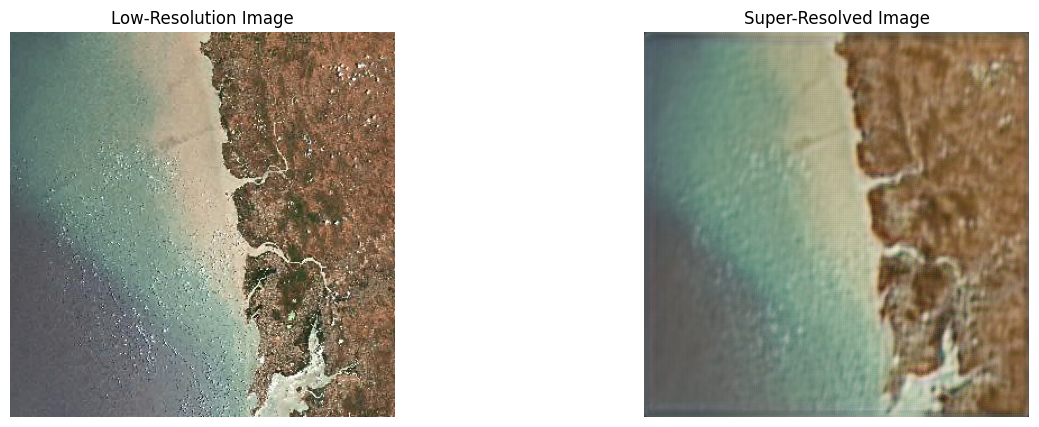

In [ ]:
import torch
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

# Load the trained generator model
checkpoint_path = '/content/drive/MyDrive/Sentinel - 2 Images/netG.pth'
netG = Generator(UPSCALE_FACTOR)
netG.load_state_dict(torch.load(checkpoint_path))
netG.eval()


checkpoint_path_discriminator = '/content/drive/MyDrive/Sentinel - 2 Images/netD.pth'
netD = Discriminator()
netD.load_state_dict(torch.load(checkpoint_path_discriminator))
netD.eval()

# Load the low-resolution image
lr_image_path = '/content/drive/MyDrive/Sentinel - 2 Images/SEN2A_MSI_zzz_06MAY2024_005_T43QBB_ESA_STUBBAOJD_20240506T094758.jpg'
lr_image = Image.open(lr_image_path).convert('RGB')

# Preprocess the LR image
preprocess_lr = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize to a smaller resolution
    transforms.ToTensor(),  # Convert to tensor

])

# Apply preprocessing to LR image
lr_image_tensor = preprocess_lr(lr_image).unsqueeze(0)

# Use both generator and discriminator for inference
with torch.no_grad():
    # Generate super-resolved image
    sr_image_tensor = netG(lr_image_tensor).clamp(0, 1)

# Convert refined SR image tensor to PIL image
sr_image_pil = TF.to_pil_image(sr_image_tensor.squeeze(0))

# Plot LR, SR, and refined SR images side by side
plt.figure(figsize=(15, 5))

# Plot LR image
plt.subplot(1, 2, 1)
plt.imshow(lr_image)
plt.title('Low-Resolution Image')
plt.axis('off')

# Plot refined SR image
plt.subplot(1, 2, 2)
plt.imshow(sr_image_pil)
plt.title('Super-Resolved Image')
plt.axis('off')

plt.show()

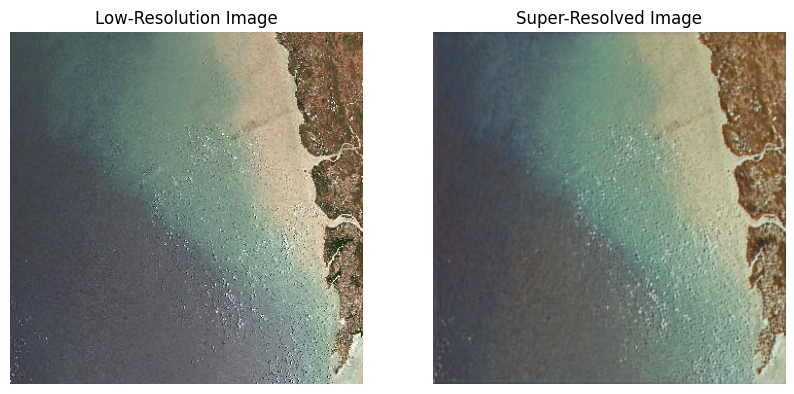

In [ ]:
# Load the trained generator model
checkpoint_path = '/content/drive/MyDrive/Sentinel - 2 Images/netG.pth'
netG = Generator(10)
netG.load_state_dict(torch.load(checkpoint_path))
netG.eval()

# Load the low-resolution image
lr_image_path = '/content/drive/MyDrive/Sentinel - 2 Images/SEN2A_MSI_zzz_06MAY2024_005_T42QZG_ESA_STUBBAOJD_20240506T094758.jpg'
lr_image = Image.open(lr_image_path).convert('RGB')

# Preprocess the LR image
preprocess_lr = transforms.Compose([
    transforms.Resize((600, 600)),  # Resize to a smaller resolution
    transforms.ToTensor(),  # Convert to tensor

])

# Apply preprocessing to LR image
lr_image_tensor = preprocess_lr(lr_image).unsqueeze(0)

# Perform Super-Resolution
with torch.no_grad():
    sr_image_tensor = netG(lr_image_tensor).clamp(0, 1)

# Convert SR image tensor to PIL image
sr_image_pil = TF.to_pil_image(sr_image_tensor.squeeze(0))
lr_image_pil = TF.to_pil_image(lr_image_tensor.squeeze(0))

# Plot LR and SR images side by side
plt.figure(figsize=(10, 5))

# Plot LR image
plt.subplot(1, 2, 1)
plt.imshow(lr_image)
plt.title('Low-Resolution Image')
plt.axis('off')

# Plot SR image
plt.subplot(1, 2, 2)
plt.imshow(sr_image_pil)
plt.title('Super-Resolved Image')
plt.axis('off')

plt.show()